In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot

# Notebook 7: Validation by Geodesic Interpolation

In this notebook we test our ability to interpolate the distribution of cells at held-out time-points. 
Intuitively, the developmental process $\mathbb{P}_t$ traces out a *curve in the space of distributions*.
We sample cells at various time points and obtain noisy samples along this curve.
Optimal transport allows us to connect these noisy samples with straight lines (aka *geodesics*) in the space of distributions. This allows us to interpolate the distribution of cells at intermediate time-points. 
We can therefore test the performance of OT by holding out time-points and  comparing our interpolation estimate to the real held-out data.

We begin by initializing an OT Model for the serum time-course using pre-computed growth rates (stored in the file `serum_g.txt` created in Notebook 2). 

In [2]:
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
LEARNED_GROWTH_SCORES_PATH = 'tmaps/serum_g.txt'
BATCH_PATH = 'data/batches.txt'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'

adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, BATCH_PATH, LEARNED_GROWTH_SCORES_PATH], obs_filter=SERUM_CELL_IDS_PATH)

ot_model = wot.ot.OTModel(adata, growth_rate_field='g2',growth_iters = 1) 

We are now ready to test interpolation over a single interval from day $17$ to $18$. 
We set aside the data from day $17.5$, and we estimate the coupling from $17$ to $18$ by computing a transport map. 
We then compute an interpolating point cloud of simulated day $17.5$ cells and compare this to the real observations using earth mover's distance. 
We also compute the distance betwen batches of real observations at time $17.5$. 
This provides an estimate of the baseline noise level. 
Finally, we also compute distances between the real point cloud at $17.5$ and several null-estimates different from OT. These include
* an interoplation using a random coupling
* the first point in the interval (day 17.0 cells)
* the last point in the interval (day 18.0 cells)

The function `compute_validation_summary` returns a table containing all these point-cloud distances.

In [3]:
interp_summary = wot.ot.compute_validation_summary(ot_model, day_triplets=[(17, 17.5, 18)])

This produces a table `interp_summary` which contains all the distances between point clouds described above. 

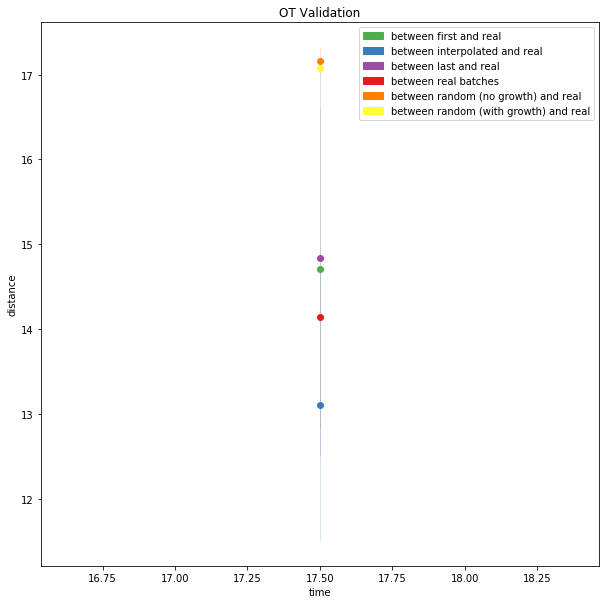

In [5]:
wot.graphics.plot_ot_validation_summary_stats(interp_summary.groupby(['interval_mid', 'name'])['distance'].agg([np.mean, np.std]))

We now use the `compute_validation_summary` function to check the quality of interpolation at *each* triplet of consecutive time-points $(t_i,t_{i+1},t_{i+2})$. For each triple, we
* hold out the data from time $t_{i+1}$,
* estimate the coupling $\gamma_{t_i,t_{i+2}}$ connecting time $t_{i}$ to $t_{i+2}$,
* compute an interpolating distribution at time $t_{i+1}$,
* and compare this to the held-out data $\hat{\mathbb{P}}_{t_{i+1}}$.

If the held-out data consists of multiple batches (e.g. $\hat{\mathbb{P}}_{t_{i+1}}^{(1)}$ and $\hat{\mathbb{P}}_{t_{i+1}}^{(2)}$), then we compare those to each other to estimate the baseline noise level.

We also compare several null models to the held-out data.

In [6]:
all_triplets_summary = wot.ot.compute_validation_summary(ot_model)

# save results
all_triplets_summary.to_csv('data/serum_validation_summary.txt')
all_triplets_stats = all_triplets_summary.groupby(['interval_mid', 'name'])['distance'].agg([np.mean, np.std])
all_triplets_stats.to_csv('data/serum_validation_summary_stats.txt')

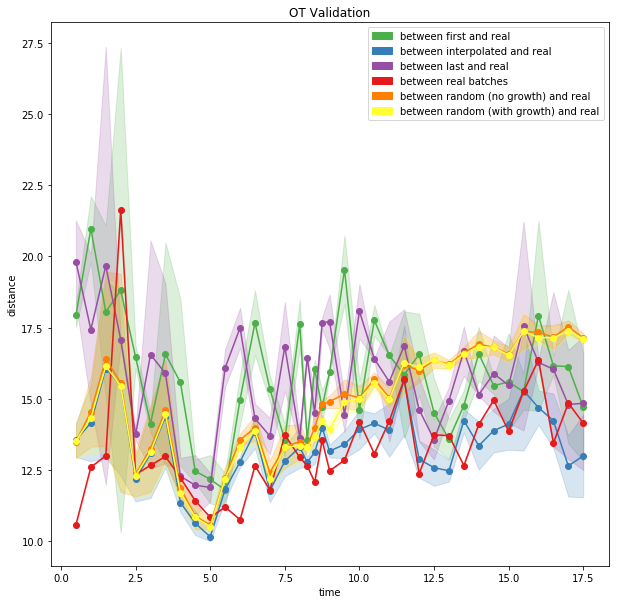

In [7]:
# read in and plot results
all_triplets_stats = pd.read_csv('data/serum_validation_summary_stats.txt')
wot.graphics.plot_ot_validation_summary_stats(all_triplets_stats)